The purpose of this notebook is to identify ancestry-associated genes

In [1]:
#Load packages
library(tidyverse)
library(reshape2)
library(ggrepel)

#Load functions
show_msg <- function(x){ 
    print(x)
    flush.console()
}

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [2]:
#Load in the rfmix data
setwd('/home/jupyter/Ancestry/rfmix')
rfmix.file.list = list.files(path = ".", pattern = ".Q")
rfmix.file.list

#Compile it all into a single object
rfmix.data = NULL #create an empty object to hold the data
index = 0 #define the for loop index
for(file in rfmix.file.list){
    index = index + 1 #increase the index
    
    
    #Load in and format the data
    individual.chromosome = read.table(file, fill = TRUE) %>%
    rename("sample" = 1, "AFR" = 2, "AMR" = 3, "EAS" = 4, "EUR" = 5, "SAS" = 6) %>%
    select(-sample)
    
    
    
    #Add the data to the main data frame
    if(index == 1) {
        rfmix.data = individual.chromosome
    } else {
        rfmix.data = rfmix.data + individual.chromosome
    }
    
    
    
    #Divide the data by the number of chromosomes to get the ancestry fraction across the genome
    if(index == length(rfmix.file.list)) {
        rfmix.data = rfmix.data/length(rfmix.file.list)
    }
    
    
    
    #Re-add the sample names
    if(index == length(rfmix.file.list)){
        sample.names = read.table(file, fill = TRUE) %>%
        rename("sample" = 1) %>%
        pull(sample) 
        
    rfmix.data = rfmix.data %>%
        mutate(sample = sample.names, .before = "AFR")
    }
    
}

head(rfmix.data)
write.table(rfmix.data, "collapsed.ancestry.information.txt", sep = "\t", col.names = TRUE)

[1] "chr1.rfmix.output.rfmix.Q"  "chr10.rfmix.output.rfmix.Q"
 [3] "chr11.rfmix.output.rfmix.Q" "chr12.rfmix.output.rfmix.Q"
 [5] "chr13.rfmix.output.rfmix.Q" "chr14.rfmix.output.rfmix.Q"
 [7] "chr15.rfmix.output.rfmix.Q" "chr16.rfmix.output.rfmix.Q"
 [9] "chr17.rfmix.output.rfmix.Q" "chr18.rfmix.output.rfmix.Q"
[11] "chr19.rfmix.output.rfmix.Q" "chr2.rfmix.output.rfmix.Q" 
[13] "chr20.rfmix.output.rfmix.Q" "chr21.rfmix.output.rfmix.Q"
[15] "chr22.rfmix.output.rfmix.Q" "chr3.rfmix.output.rfmix.Q" 
[17] "chr4.rfmix.output.rfmix.Q"  "chr5.rfmix.output.rfmix.Q" 
[19] "chr6.rfmix.output.rfmix.Q"  "chr7.rfmix.output.rfmix.Q" 
[21] "chr8.rfmix.output.rfmix.Q"  "chr9.rfmix.output.rfmix.Q"

,sample,AFR,AMR,EAS,EUR,SAS
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000657,0.9601677273,0.0005504545,0.0063213636,0.03192409,0.0010363636
2,ACH-000617,0.0028859091,0.0204050000,0.0000000000,0.97557545,0.0011336364
3,ACH-000685,0.8539895455,0.0272740909,0.0395313636,0.07403591,0.0051686364
4,ACH-000632,0.0025995455,0.0009922727,0.0001513636,0.99553364,0.0007231818
5,ACH-000171,0.0007454545,0.0000000000,0.0010822727,0.99686682,0.0013054545
6,ACH-000863,0.0065409091,0.0000000000,0.0036922727,0.96728000,0.0224868182


In [4]:
#Load in the uncorrected chronos data and format it
setwd('/home/jupyter/Ancestry/gwas')
uncorrected.ccle.chronos = read.table('CRISPR_gene_effect.csv', sep = ",", header = T, check.names = FALSE) %>%
rename( "sample" = 1) %>%
setNames(word(names(.), 1)) 
head(uncorrected.ccle.chronos)

,sample,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000001,-0.14789625,0.05463471,0.001419604,-0.01339043,-0.10349883,-0.01125857,0.006416150,-0.3134714,0.006768761,⋯,-0.07102683,-0.09653835,-0.02783783,0.109681058,0.15538259,-0.11208185,0.08538044,0.155184455,0.063520777,-0.33008466
2,ACH-000004,0.04225404,-0.03722391,-0.110746309,-0.01216771,0.04928672,-0.13341834,0.146940684,-0.2059332,0.110355464,⋯,-0.03456611,-0.24942696,0.10866321,0.038576149,0.05678273,0.06712849,-0.16562203,0.127003760,0.112792741,-0.02744917
3,ACH-000005,-0.09725072,0.03138132,0.056310037,0.14384058,-0.01691672,-0.16512957,0.129443530,-0.2582329,-0.078755273,⋯,-0.07883775,-0.24704082,-0.04526586,-0.004562731,-0.02503393,-0.12468651,-0.11999691,0.047232733,-0.008179104,-0.09600739
4,ACH-000007,-0.02114864,-0.08354835,0.064540722,0.07293326,-0.02168035,-0.03812946,-0.019298595,-0.2071468,-0.065116712,⋯,-0.25412460,-0.46013587,0.05273457,0.162883734,0.10396785,-0.02976377,-0.17820933,-0.126332483,-0.185517858,-0.28405535
5,ACH-000009,-0.02221356,-0.03932445,0.068163523,0.07960398,0.02605992,-0.07865008,-0.008861441,-0.1818317,0.010320843,⋯,-0.19291138,-0.33573379,0.01216716,0.189156924,-0.04495579,-0.13131152,-0.33177966,-0.002488554,-0.068758583,-0.22810072
6,ACH-000011,0.07938469,-0.05681123,0.046281449,0.21295376,-0.09828782,-0.23423752,-0.067585065,-0.1514126,0.047989598,⋯,-0.51411266,-0.48357923,0.05012691,0.116754733,0.21111247,0.08775948,-0.12456308,-0.119781600,-0.120450263,-0.21757298


In [5]:
#Load in the corrected chronos data and format it
setwd('/home/jupyter/Ancestry/gwas')
corrected.ccle.chronos = read.table('AncestryBias-Achilles_gene_effect_public_subset.csv', sep = ",", header = T, check.names = FALSE) %>%
rename( "sample" = 1) %>%
setNames(word(names(.), 1)) 
head(corrected.ccle.chronos)

,sample,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000004,0.086438855,-0.005375553,-2.183470e-01,-0.008364505,0.16417069,-0.15868934,0.13873398,-0.3513665,0.16154247,⋯,-0.049223665,-0.20606886,0.04893834,-0.04113926,0.11126043,0.13950968,-0.24126582,0.184734547,0.14995786,0.02054175
2,ACH-000005,-0.036344709,0.052274951,-4.114512e-05,0.117234004,0.11821882,-0.22455174,0.12412216,-0.3888416,-0.04671770,⋯,-0.009955124,-0.21194361,-0.25071171,-0.14646951,0.04277384,-0.16129096,-0.25317451,0.090689833,-0.08150250,-0.01915329
3,ACH-000007,0.022240345,0.006156480,-3.891893e-02,0.030215966,0.02884721,0.09573301,-0.02835576,-0.3795737,-0.09470061,⋯,-0.094843570,-0.17126918,0.03239710,0.16271137,0.17475661,-0.05636008,-0.21270069,-0.149988953,-0.29615284,-0.24754145
4,ACH-000009,0.005645809,-0.008697106,8.763318e-03,-0.011197381,0.18368258,-0.05274889,0.01991085,-0.4722547,0.08671924,⋯,-0.128498754,-0.05410665,-0.04810827,0.14430389,0.05453465,0.04482793,-0.46759979,0.110258803,-0.05243945,-0.30358156
5,ACH-000011,0.131006340,0.097061285,9.461156e-03,0.204017306,0.04543504,-0.20395109,0.05076659,-0.2199503,0.11424052,⋯,-0.461831735,-0.35449242,0.03969045,0.12868549,0.25400347,0.22500652,-0.11199388,-0.004686198,-0.11029634,-0.04172295
6,ACH-000012,-0.076204036,0.084348153,1.436267e-01,0.209373167,0.17615320,-0.19905234,0.21219832,-0.2505001,0.05307951,⋯,-0.419282699,-0.95234213,-0.01555762,-0.01956584,0.10287621,0.14251752,-0.07013547,0.001880521,-0.07368321,-0.15401379


In [6]:
#Load in the sample annotation data
setwd('/home/jupyter/Ancestry/ccle_ancestry_analysis')
sample.annotation = read.table('depmap_cell_lineage.csv', sep = ",", header = T) %>%
rename("sample" = 1)

head(sample.annotation)

,sample,primary_disease
,<chr>,<chr>
1,ACH-000001,Ovarian Cancer
2,ACH-000002,Leukemia
3,ACH-000003,Colon/Colorectal Cancer
4,ACH-000004,Leukemia
5,ACH-000005,Leukemia
6,ACH-000006,Leukemia


In [7]:
#Merge all of the datasets together for uncorrected
uncorrected.merged.dataset = rfmix.data %>%
inner_join(., sample.annotation) %>%
inner_join(., uncorrected.ccle.chronos)

#Merge all of the datasets together for corrected
corrected.merged.dataset = rfmix.data %>%
inner_join(., sample.annotation) %>%
inner_join(., corrected.ccle.chronos)



Joining, by = "sample"

Joining, by = "sample"

Joining, by = "sample"

Joining, by = "sample"



Compute p-values with wilcoxon test

# Compute p-values for the uncorrected datasets

In [61]:
#Compute wilcoxon p-values for uncorrected afr
uncorrected.afr.df =  uncorrected.merged.dataset %>% filter(AFR >= 0.5) %>% select(-c(1:7))
uncorrected.non.afr.df =  uncorrected.merged.dataset %>% filter(AFR < 0.5) %>% select(-c(1:7))
uncorrected.afr.wilcox.pvals = mapply(wilcox.test, x = uncorrected.afr.df, y = uncorrected.non.afr.df) %>% data.frame() %>% slice(3) %>% unlist()
print("AFR Complete!")

#Compute wilcoxon p-values for uncorrected amr
uncorrected.amr.df =  uncorrected.merged.dataset %>% filter(AMR >= 0.5) %>% select(-c(1:7))
uncorrected.non.amr.df =  uncorrected.merged.dataset %>% filter(AMR < 0.5) %>% select(-c(1:7))
uncorrected.amr.wilcox.pvals = mapply(wilcox.test, x = uncorrected.amr.df, y = uncorrected.non.amr.df) %>% data.frame() %>% slice(3) %>% unlist()
print("AMR Complete!")

#Compute wilcoxon p-values for uncorrected eas
uncorrected.eas.df =  uncorrected.merged.dataset %>% filter(EAS >= 0.5) %>% select(-c(1:7))
uncorrected.non.eas.df =  uncorrected.merged.dataset %>% filter(EAS < 0.5) %>% select(-c(1:7))
uncorrected.eas.wilcox.pvals = mapply(wilcox.test, x = uncorrected.eas.df, y = uncorrected.non.eas.df) %>% data.frame() %>% slice(3) %>% unlist()
print("EAS Complete!")

#Compute wilcoxon p-values for uncorrected eur
uncorrected.eur.df =  uncorrected.merged.dataset %>% filter(EUR >= 0.5) %>% select(-c(1:7))
uncorrected.non.eur.df =  uncorrected.merged.dataset %>% filter(EUR < 0.5) %>% select(-c(1:7))
uncorrected.eur.wilcox.pvals = mapply(wilcox.test, x = uncorrected.eur.df, y = uncorrected.non.eur.df) %>% data.frame() %>% slice(3) %>% unlist()
print("EUR Complete!")

#Compute wilcoxon p-values for uncorrected sas
uncorrected.sas.df =  uncorrected.merged.dataset %>% filter(SAS >= 0.5) %>% select(-c(1:7))
uncorrected.non.sas.df =  uncorrected.merged.dataset %>% filter(SAS < 0.5) %>% select(-c(1:7))
uncorrected.sas.wilcox.pvals = mapply(wilcox.test, x = uncorrected.sas.df, y = uncorrected.non.sas.df) %>% data.frame() %>% slice(3) %>% unlist()
print("SAS Complete!")

[1] "AFR Complete!"
[1] "AMR Complete!"
[1] "EAS Complete!"
[1] "EUR Complete!"
[1] "SAS Complete!"


In [62]:
#Combine the uncorrected dataset together
uncorrected.wilcox.pvals.df = cbind(names(uncorrected.afr.wilcox.pvals), uncorrected.afr.wilcox.pvals, uncorrected.amr.wilcox.pvals, uncorrected.eas.wilcox.pvals, uncorrected.eur.wilcox.pvals, uncorrected.sas.wilcox.pvals) %>%
data.frame() %>%
rename("gene" = 1, "AFR" = 2, "AMR" = 3, "EAS" = 4, "EUR" = 5, "SAS" = 6) %>%
mutate(AFR = as.numeric(AFR)) %>%
mutate(AMR = as.numeric(AMR)) %>%
mutate(EAS = as.numeric(EAS)) %>%
mutate(EUR = as.numeric(EUR)) %>%
mutate(SAS = as.numeric(SAS)) %>%
mutate(gene = gsub("\\..*", "", gene))

uncorrected.wilcox.pvals.df %>% arrange(EAS) %>% head()

,gene,AFR,AMR,EAS,EUR,SAS
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CLSPN.p.value,CLSPN,0.01067045,0.7083125,2.080869e-22,3.874113e-27,0.16798728
UGT2B17.p.value,UGT2B17,0.35707090,0.2344864,2.878330e-14,7.283254e-12,0.83378880
RHD.p.value,RHD,0.00115210,0.2301524,1.101590e-13,1.353829e-08,0.08125034
INCENP.p.value,INCENP,0.84213208,0.1793278,6.709175e-12,2.415207e-11,0.59390646
RIMS2.p.value,RIMS2,0.52574813,0.7838101,5.582087e-11,4.745656e-09,0.07273862
RPS5.p.value,RPS5,0.96346082,0.2640680,8.716616e-11,1.147246e-10,0.78515908


# Compute p-values for the corrected datasets

In [10]:
#Compute wilcoxon p-values for corrected afr
afr.df =  corrected.merged.dataset %>% filter(AFR >= 0.5) %>% select(-c(1:7))
non.afr.df =  corrected.merged.dataset %>% filter(AFR < 0.5) %>% select(-c(1:7))
afr.wilcox.pvals = mapply(wilcox.test, x = afr.df, y = non.afr.df) %>% data.frame() %>% slice(3) %>% unlist()
print("AFR Complete!")

#Compute wilcoxon p-values for corrected amr
amr.df =  corrected.merged.dataset %>% filter(AMR >= 0.5) %>% select(-c(1:7))
non.amr.df =  corrected.merged.dataset %>% filter(AMR < 0.5) %>% select(-c(1:7))
amr.wilcox.pvals = mapply(wilcox.test, x = amr.df, y = non.amr.df) %>% data.frame() %>% slice(3) %>% unlist()
print("AMR Complete!")

#Compute wilcoxon p-values for corrected eas
eas.df =  corrected.merged.dataset %>% filter(EAS >= 0.5) %>% select(-c(1:7))
non.eas.df =  corrected.merged.dataset %>% filter(EAS < 0.5) %>% select(-c(1:7))
eas.wilcox.pvals = mapply(wilcox.test, x = eas.df, y = non.eas.df) %>% data.frame() %>% slice(3) %>% unlist()
print("EAS Complete!")

#Compute wilcoxon p-values for corrected eur
eur.df =  corrected.merged.dataset %>% filter(EUR >= 0.5) %>% select(-c(1:7))
non.eur.df =  corrected.merged.dataset %>% filter(EUR < 0.5) %>% select(-c(1:7))
eur.wilcox.pvals = mapply(wilcox.test, x = eur.df, y = non.eur.df) %>% data.frame() %>% slice(3) %>% unlist()
print("EUR Complete!")

#Compute wilcoxon p-values for corrected sas
sas.df =  corrected.merged.dataset %>% filter(SAS >= 0.5) %>% select(-c(1:7))
non.sas.df =  corrected.merged.dataset %>% filter(SAS < 0.5) %>% select(-c(1:7))
sas.wilcox.pvals = mapply(wilcox.test, x = sas.df, y = non.sas.df) %>% data.frame() %>% slice(3) %>% unlist()
print("SAS Complete!")

[1] "AFR Complete!"
[1] "AMR Complete!"
[1] "EAS Complete!"
[1] "EUR Complete!"
[1] "SAS Complete!"


In [63]:
#Combine the corrected dataset together
corrected.wilcox.pvals.df = cbind(names(afr.wilcox.pvals), afr.wilcox.pvals, amr.wilcox.pvals, eas.wilcox.pvals, eur.wilcox.pvals, sas.wilcox.pvals) %>%
data.frame() %>%
rename("gene" = 1, "AFR" = 2, "AMR" = 3, "EAS" = 4, "EUR" = 5, "SAS" = 6) %>%
mutate(AFR = as.numeric(AFR)) %>%
mutate(AMR = as.numeric(AMR)) %>%
mutate(EAS = as.numeric(EAS)) %>%
mutate(EUR = as.numeric(EUR)) %>%
mutate(SAS = as.numeric(SAS)) %>%
mutate(gene = gsub("\\..*", "", gene))

,gene,AFR,AMR,EAS,EUR,SAS
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CBS.p.value,CBS,0.56416361,0.2906301,1.179645e-13,9.526866e-13,0.3183065
XCL1.p.value,XCL1,0.02495873,0.2372857,2.179269e-13,2.122877e-10,0.9488354
CCDC74B.p.value,CCDC74B,0.59595001,0.1521683,1.326276e-12,2.716054e-12,0.5428543
LRRC37A2.p.value,LRRC37A2,0.37729790,0.9153449,5.076071e-12,3.450732e-12,0.2753262
RHD.p.value,RHD,0.03559869,0.2551088,3.338977e-11,5.657845e-08,0.1763812
OR2T5.p.value,OR2T5,0.54399162,0.4682456,1.311036e-10,6.542644e-11,0.1865002


In [65]:
#Get the intersecting genes between the two datasets
intersecting.genes = intersect(corrected.wilcox.pvals.df$gene, uncorrected.wilcox.pvals.df$gene)

#Filter the two datasets to only include these genes, melt, then calculate the fdr
corrected.fdr = corrected.wilcox.pvals.df %>%
filter(gene %in% intersecting.genes) %>%
distinct(gene, .keep_all = TRUE) %>%
arrange(gene) %>%
melt() %>%
mutate(fdr = p.adjust(value, method = "BH", n = length(value)))


uncorrected.fdr = uncorrected.wilcox.pvals.df %>%
filter(gene %in% intersecting.genes) %>%
distinct(gene, .keep_all = TRUE) %>%
arrange(gene) %>%
melt() %>%
mutate(fdr = p.adjust(value, method = "BH", n = length(value)))

Using gene as id variables

Using gene as id variables



,gene,variable,value,fdr
,<chr>,<fct>,<dbl>,<dbl>
1,A1BG,AFR,0.06352433,0.8523017
2,A1CF,AFR,0.38001646,0.8991668
3,A2M,AFR,0.87089536,0.9893269
4,A2ML1,AFR,0.33230561,0.8834758
5,A3GALT2,AFR,0.32238916,0.8789649
6,A4GALT,AFR,0.36322306,0.8940203


,gene,variable,value,fdr
,<chr>,<fct>,<dbl>,<dbl>
1,A1BG,AFR,0.07711508,0.8260168
2,A1CF,AFR,0.01553919,0.7618980
3,A2M,AFR,0.82128228,0.9772790
4,A2ML1,AFR,0.66475156,0.9475206
5,A3GALT2,AFR,0.89568474,0.9866868
6,A4GALT,AFR,0.52781139,0.9159267


[1] 86650     4

[1] 86650     4

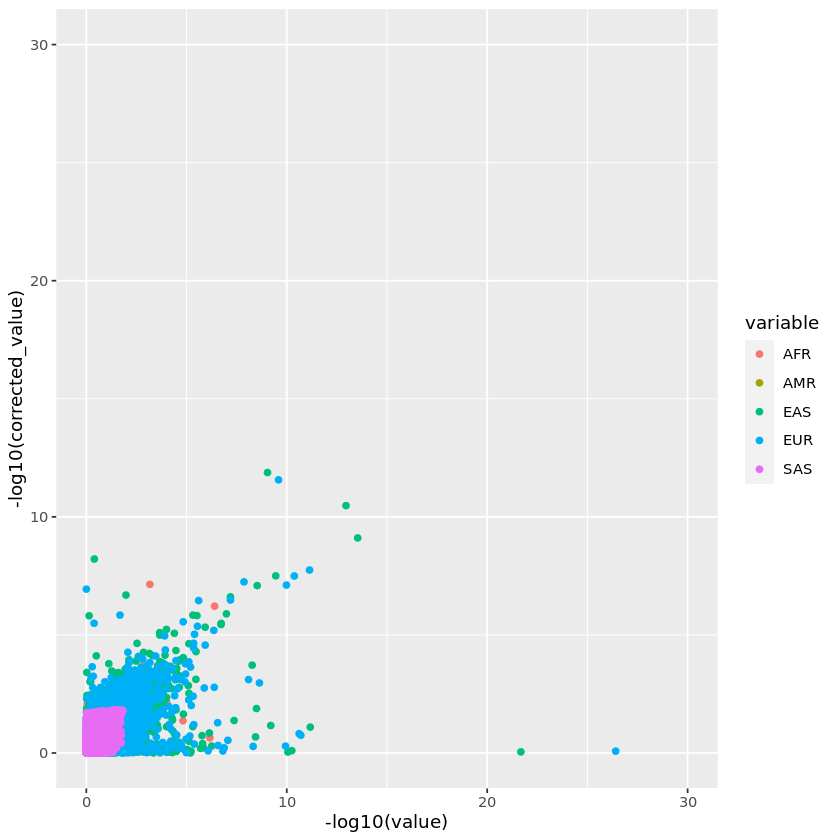

In [71]:
#Plot the plot!
uncorrected.fdr %>%
mutate(corrected_value = corrected.fdr$value) %>%
mutate(corrected_fdr = corrected.fdr$fdr) %>%

ggplot() +
geom_point(aes(x = -log10(value), y = -log10(corrected_value), color = variable)) +

scale_x_continuous(limits = c(0, 30)) +
scale_y_continuous(limits = c(0, 30))


In [78]:
uncorrected.fdr %>%
filter(fdr < 0.05) %>%
pull(gene) %>%
unique() 

corrected.fdr %>%
filter(fdr < 0.05) %>%
pull(gene) %>%
unique() 

[1] "EEF2"      "NUP133"    "RESP18"    "ACAN"      "ADCY3"     "BTG1"     
 [7] "C22orf31"  "C2orf80"   "CBFA2T2"   "CCDC102B"  "CCDC74B"   "CCL3"     
[13] "CEP19"     "CHGB"      "CLSPN"     "COX6B1"    "DCN"       "DDX47"    
[19] "DND1"      "ECD"       "EGFR"      "FAM25A"    "FCGR3A"    "FRG2C"    
[25] "GLYCTK"    "GRB2"      "GTPBP3"    "HCN2"      "HINT3"     "HIST1H2AA"
[31] "HLA"       "HNF1B"     "INCENP"    "ITGA3"     "ITIH3"     "KIAA2013" 
[37] "MATR3"     "MRTO4"     "MYH11"     "NAA40"     "NIT2"      "NKAIN4"   
[43] "NOP56"     "NPEPPS"    "NPHS1"     "PDXDC1"    "PEX11A"    "PTPN11"   
[49] "QRICH2"    "RAB21"     "RETNLB"    "RHD"       "RIMS2"     "RPL3"     
[55] "RPS5"      "RTP5"      "SART1"     "SCN5A"     "SLC10A5"   "SLC35B2"  
[61] "SLC38A7"   "SLC5A11"   "SNAP23"    "SPATA6L"   "SRP14"     "STX4"     
[67] "STXBP3"    "TPSD1"     "TRMT61B"   "TTC4"      "TUT1"      "TXNRD1"   
[73] "UGT2B17"   "VRK1"      "WSB2"      "ZNF675"    "APEX2"     "ATRX"     
[79] "C17orf64"  "COPG1"     "CSE1L"     "DEFB108B"  "ERI1"      "FAM86C1"  
[85] "IL1RN"     "KRT14"     "LPAR6"     "MDN1"      "NOMO2"     "PCBP4"    
[91] "PSPH"      "RPP30"     "SERINC2"   "XYLT2"     "ZFP62"

[1] "DHRS4"   "RESP18"  "AKR1B10" "ARSG"    "C2orf80" "CCDC74B" "CCL3"   
 [8] "FCGR3A"  "FRG2C"   "GRB2"    "KRT6B"   "MESP1"   "NPEPPS"  "PDXDC1" 
[15] "PTPN11"  "RHD"     "RRP7A"   "SNAP23"  "SRP14"   "UGT2B17" "ZYG11A" 
[22] "VRK1"